<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 一幅图有很多局部极大值，如何 argmax 得到坐标？
* 两个相距很近的高斯，中间会不会鼓起来，比两边的峰值还高？如何 argmax 找到两边峰值的位置，而不是中间鼓包的位置？
* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['DataPreprocessing.ipynb',
 'Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'Heatmap_each.ipynb']

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb

import warnings
warnings.filterwarnings('ignore')


In [3]:
from utils.network import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. Data Preparation

In [5]:
train_size = 200
test_size = 200

In [6]:
with open("datasets/cropped_helen/helen_cropped_train_pts.json",'r') as htrain:
  htrain_pts = json.load(htrain)
with open("datasets/cropped_helen/helen_cropped_test_pts.json",'r') as htest:
  htest_pts = json.load(htest)

In [7]:
# Load pictures
train_tensor = torch.zeros((train_size,3,224,224))
train_label = torch.zeros((train_size,68,2))
i=0
for train_key in htrain_pts.keys():
  path = os.path.join("datasets/cropped_helen/trainset", train_key + '.jpg')
  pic = cv2.imread(path)
  pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  train_tensor[i,:,:,:] = torch.from_numpy(pic).permute(2,0,1)

  train_label[i,:,:] = torch.Tensor(htrain_pts[train_key])

  if (i+1)%40 == 0:
    print('Caught [%d/%d] pictures......' %(i+1,train_size))

  if i == train_size-1:
    break
  else: i+=1
train_tensor = train_tensor.to(device)
train_label = train_label.reshape(train_size,-1)
train_label[:,1::2] = 224 - train_label[:,1::2]
train_label = train_label.to(device)

Caught [40/200] pictures......
Caught [80/200] pictures......
Caught [120/200] pictures......
Caught [160/200] pictures......
Caught [200/200] pictures......


In [8]:
# Load pictures
# test_tensor = torch.zeros((test_size,3,224,224))
# test_label = torch.zeros((test_size,68,2))
# i=0
# for test_key in htest_pts.keys():
#   path = os.path.join("datasets/cropped_helen/testset", test_key + '.jpg')
#   pic = cv2.imread(path)
#   pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
#   test_tensor[i,:,:,:] = torch.from_numpy(pic).permute(2,0,1)

#   test_label[i,:,:] = torch.Tensor(htest_pts[test_key])

#   if (i+1)%40 == 0:
#     print('Caught [%d/%d] pictures......' %(i+1,test_size))

#   if i == test_size-1:
#     break
#   else: i+=1
# test_label = test_label.reshape(test_size,-1)
# test_label[:,1::2] = 224-test_label[:,1::2]

# 3. Make Heatmap Label

In [9]:
def get_heatmap_each(label, var):
  ########
  ## label(200,136) var:scalar
  ########
  N = label.shape[0]
  npts = int(label.shape[1]/2)
  gaussian_map = torch.zeros((N,npts,224,224))

  large_gaussian = torch.zeros((501,501))
  for i in range(501):
    for j in range(501):
      numb = torch.tensor(((i-250)**2+(j-250)**2)/2/(var**2))
      large_gaussian[i,j] = torch.exp(-numb)

  for n in range(N):
    for p in range(npts):
      x = int(label[n,2*p])
      y = int(label[n,2*p+1])
      gaussian_map[n,p,:,:] = large_gaussian[250-x:474-x,250-y:474-y]


  #gaussian_map[gaussian_map<0.01] = 0

  return gaussian_map


In [10]:
var = 3
train_heatmap = get_heatmap_each(train_label,var).to(device)
#test_heatmap = get_heatmap_each(test_label,var).to(device)

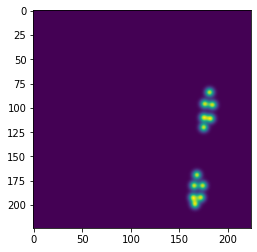

In [33]:
nimg = 0
plt.imshow(torch.sum(train_heatmap[nimg,36:48,:,:],axis=0).cpu())

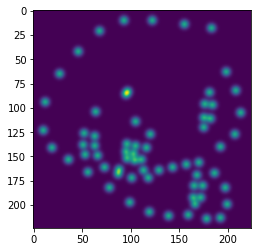

In [21]:
plt.imshow(torch.sum(train_heatmap[nimg,:,:,:],axis=0).cpu())

This picture seems rotated because x and y axis are different between `plt.imshow` and `torch.tensor`.

# 3. Heatmap Regression

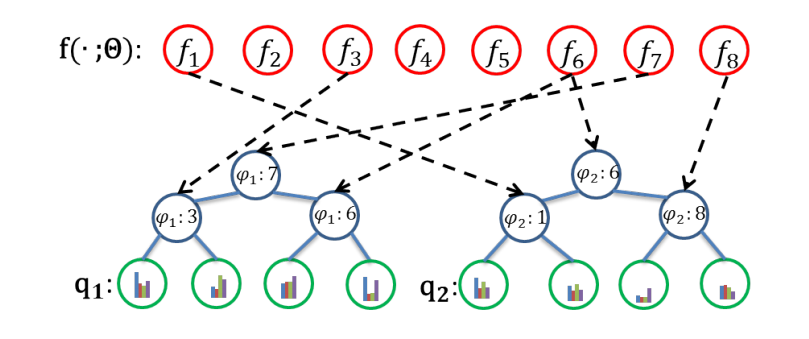

In [12]:
def phi(cnn_fc):
  device = cnn_fc.device
  N,C = cnn_fc.shape
  out = torch.zeros(N,C).to(device)

  phi1l = cnn_fc[:,2]*torch.sigmoid(cnn_fc[:,6])
  phi1r = cnn_fc[:,5]*(1-torch.sigmoid(cnn_fc[:,6]))
  phi2l = cnn_fc[:,0]*torch.sigmoid(cnn_fc[:,5])
  phi2r = cnn_fc[:,7]*(1-torch.sigmoid(cnn_fc[:,5]))

  out[:,0] = torch.sigmoid(phi1l)
  out[:,1] = 1-torch.sigmoid(phi1l)
  out[:,2] = torch.sigmoid(phi1r)
  out[:,3] = 1-torch.sigmoid(phi1r)
  out[:,4] = torch.sigmoid(phi2l)
  out[:,5] = 1-torch.sigmoid(phi2l)
  out[:,6] = torch.sigmoid(phi2r)
  out[:,7] = 1-torch.sigmoid(phi2r)

  return out

In [34]:
def find_coord(prob_map):
  # prob_map(200,68*224*224)

  N = prob_map.shape[0]
  P = 12
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,224,224).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [53]:
#######################
# Initialization
Total_train = 5

# CNN initilization
heatmap_train_label = train_heatmap.reshape(train_size,68,-1)
heatmap_train_label = heatmap_train_label/torch.sum(heatmap_train_label,axis=2,keepdims=True)

learning_rate = 3e-4
criterion = nn.MSELoss()

num_epochs = 100
heatmap_cnn = CNN_module().to(device)
optimizer = torch.optim.Adam(heatmap_cnn.parameters(),lr=learning_rate)

RuntimeError: ignored

In [59]:
cnn_loss_hist = torch.zeros(num_epochs)
for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  

  # Train Regression Trees
  if round == 0:
    leaf_q = torch.ones(8,12*224*224).to(device)/(224*224)
    cnn_prob = torch.ones(train_size,8).to(device)/8
  

  with torch.no_grad():
    pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
    loss0 = torch.sum(torch.abs(pred_coord0-train_label[:,72:96]))

    htrain_reshape = heatmap_train_label[:,36:48,:].reshape(train_size,-1)
    leaf_q = torch.matmul(torch.linalg.pinv(cnn_prob), htrain_reshape) #(8,68*224*224)

    pred_coord1 = find_coord(torch.matmul(cnn_prob,leaf_q))
    loss1 = torch.sum(torch.abs(pred_coord1-train_label[:,72:96]))
    print("     RF training loss: %.4f -> %.4f" %(loss0, loss1))


  # Train CNN
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = heatmap_cnn(train_tensor) #(200,8)
    cnn_prob = phi(outputs)
  
    # Points predicted by CNN
    loss = criterion(torch.matmul(cnn_prob,leaf_q), heatmap_train_label[:,36:48,:].reshape(200,-1))
    cnn_loss_hist[epoch] = loss.item()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 20 == 0 or epoch == 0:
      print('    CNN: Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.item()*train_size))
  

###########################################################
Round 1, Using GPU
     RF training loss: 679590.1250 -> 75525.9219
    CNN: Epoch [1/100], Loss: 1512068700.0000
    CNN: Epoch [20/100], Loss: 43571265.6250
    CNN: Epoch [40/100], Loss: 40328128.1250
    CNN: Epoch [60/100], Loss: 6726683.5938
    CNN: Epoch [80/100], Loss: 3697477.3438
    CNN: Epoch [100/100], Loss: 3037460.9375
###########################################################
Round 2, Using GPU
     RF training loss: 86958.3516 -> 65947.8125
    CNN: Epoch [1/100], Loss: 0.2148
    CNN: Epoch [20/100], Loss: 0.2116
    CNN: Epoch [40/100], Loss: 0.2103
    CNN: Epoch [60/100], Loss: 0.2111
    CNN: Epoch [80/100], Loss: 0.2098
    CNN: Epoch [100/100], Loss: 0.2104
###########################################################
Round 3, Using GPU
     RF training loss: 66711.3750 -> 84029.2500
    CNN: Epoch [1/100], Loss: 0.1355
    CNN: Epoch [20/100], Loss: 0.1323
    CNN: Epoch [40/100], Loss: 0.1318
    CNN:

In [92]:
pred_heatmap = torch.matmul(cnn_prob,leaf_q) # (200,12*224*224)
pred_coord = find_coord(pred_heatmap)
pred_heatmap = pred_heatmap.reshape(200,12,224,224)*2
pred_heatmap[pred_heatmap<0.1]=0

(0.0, 224.0)

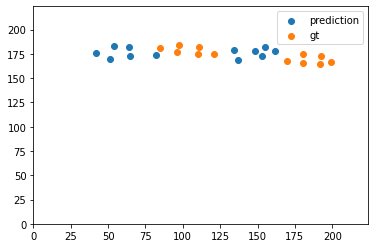

In [81]:
nimg = 0
x = pred_coord[nimg,::2].cpu()
y = pred_coord[nimg,1::2].cpu()
plt.scatter(x,y,label="prediction")

x2 = train_label[nimg,72:96:2].cpu()
y2 = train_label[nimg,73:96:2].cpu()
plt.scatter(x2,y2,label="gt")

plt.legend()
plt.xlim(0,224)
plt.ylim(0,224)

plt.title("Coordinates")

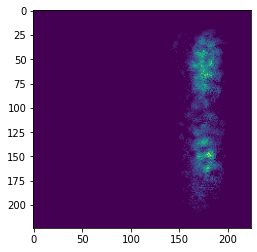

In [96]:
nimg = 0
# predicted heatmap
plt.imshow(torch.sum(pred_heatmap[nimg,:,:,:],axis=0).cpu().detach().numpy())

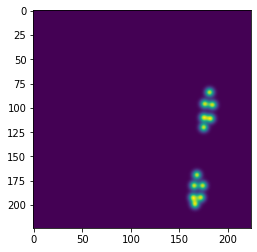

In [87]:
# gt heatmap
plt.imshow(torch.sum(train_heatmap[nimg,36:48,:,:],axis=0).cpu())